In [11]:
import numpy as np
import gym
from guaranteed_control.intervals.interval import Interval
import time
from guaranteed_control.ddpg.ddpg import train, DDPG, play
import tensorflow as tf
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
#http://cs229.stanford.edu/proj2013/AllenClarkStarek-MachineLearningTechniquesForOptimalSamplingBasedMotionPlanning.pdf
#Check reachability part
#Runge Kutta where?
#https://github.com/SFU-MARS/reward-shaping-ttr/blob/master/gym_foo/gym_foo/envs/DubinsCarEnv_v0.py

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

class Dubin():

    def __init__(self, state_obj=np.array([0, 0]), cost=None):

        self.obj = state_obj
        
        self.reset()

    #Careful, what is the condition on v2? depends on how much torque we give the car v1 (can't fully rotate absurdly)
        self.action_space = Interval(interval = [[-0.05, 0.05], [-0.2, 0.2]])
        self.low_action, self.high_action = self.action_space.high_low()

        self.delta_t = 1
        self.min_x, self.max_x = -1, 1
        self.min_y, self.max_y = -1, 1
        self.observation_space = Interval(interval = [[self.min_x, self.max_x], [self.min_y, self.max_y], [-np.pi, np.pi]])
        self.pos_space = Interval(interval = [[self.min_x, self.max_x], [self.min_y, self.max_y]])

        self.max_iter = 500

        self.viewer = None
        self.cost = cost

        
    def step(self, action):
        done = False


        action = np.clip(action, self.low_action, self.high_action)

        self.iteration +=1
        state = self.state
        state_ = np.zeros(state.shape)

        state_[0] = state[0] + action[0]*np.cos(state[2])*self.delta_t
        state_[1] = state[1] + action[0]*np.sin(state[2])*self.delta_t
        state_[2] = angle_normalize(state[2] + self.delta_t*action[1])


        state_[:2] = np.clip(state_[:2], *self.pos_space.high_low())

        vector_to_obj = self.obj - state_[:2]

        theta_to_obj = angle_normalize(np.pi + np.arctan2(vector_to_obj[1], vector_to_obj[0]))

        if self.iteration == self.max_iter:
            print(theta_to_obj - state_[2])
            
        self.state = state_
        cost = np.square(np.linalg.norm(vector_to_obj)) + np.sum(np.square(action))
        cost = np.square(np.linalg.norm(vector_to_obj))
        cost = self.cost((self, state_, action))
        self.reward = -np.array(cost).astype(np.float32)

        # if np.linalg.norm(vector_to_obj) < 1e-2:
        #     print("here")
        #     self.reward = np.max([self.reward, 1000])

        if self.iteration >= self.max_iter:
            done = True

        return self.state, self.reward, done, None

    
    def reset(self, input_interval=None):

        if input_interval == None:
            self.iteration = 0
            self.reward = 0
            self.state = np.array([0, 0, 0])
        else:
            self.iteration = 0
            self.reward = 0
            interval = input_interval.intervals
            try:
                self.state = np.array([np.random.uniform(low = interval[0][0], high = interval[0][1]), np.random.uniform(low = interval[1][0], high = interval[1][1]), np.random.uniform(low = interval[2][0], high = interval[2][0])])
                print(self.state)
            except RuntimeError:
                print("Bad shape for input interval, need one dimensional interval object")

        return np.array(self.state, dtype=np.float32)

        
    def render(self, mode="human"):
        screen_width = 600
        screen_height = 600

        world_width = self.max_x - self.min_x
        scale = screen_width / world_width
        car_side = 10
        car_y = 15

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)

            clearance = 10

            # car = rendering.make_circle(10/2)
            car = rendering.FilledPolygon([(-car_side/2, -car_y/2), (0, car_y/2), (car_side/2, -car_y/2)])
            # car.add_attr(rendering.Transform(translation=(0, clearance)))
            self.cartrans = rendering.Transform()
            car.add_attr(self.cartrans)
            self.cartrans.set_rotation(0)
            self.viewer.add_geom(car)

            flagx = (self.obj[0] - self.min_x) * scale
            flagy = (self.obj[1] - self.min_y) * scale
            flag_offset = (1/10) * scale
            flag = rendering.FilledPolygon(
                [(flagx+flag_offset, flagy+flag_offset), (flagx+flag_offset, flagy-flag_offset), (flagx - flag_offset, flagy-flag_offset), (flagx-flag_offset, flagy + flag_offset)]
            )
            flag.set_color(0.8, 0.8, 0)
            self.viewer.add_geom(flag)

        #This calls glRotate which implements a rotation using a rotation matrix or the rotation angle in degrees around a vector
        #RAD2DEG is dealth with in the render env
        pos_x = self.state[0]
        pos_y = self.state[1]
        self.cartrans.set_translation(
            (pos_x - self.min_x) * scale, (pos_y - self.min_y) * scale
        )
        self.cartrans.set_rotation(self.state[2]+np.pi/2)
        

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [23]:
def train(env, agent, input_interval=None, n_episodes=200, plot = True, plot_every=100):

    def env_step(action):
        state, reward, done, info = env.step(action)
        return (state.astype(np.float32), reward, int(done))

    eps_rewards = []

    for i in range(n_episodes):
        observation = env.reset(input_interval=input_interval)
        done = False
        episode_reward = 0

        while not done:
            
            if plot and i%plot_every==0:
                env.render()
            action = agent([observation]) 
            action = action
            observation_, reward, done = tf.numpy_function(env_step, [action], [tf.float32, tf.float32, tf.int8])
            
            agent.buffer.add_observation(observation, action, reward.numpy(), observation_.numpy())
            episode_reward += reward
            if agent.buffer.position >= agent.buffer.batch_size:
                agent.train()
                #agent.update_target()
            observation = observation_
            if done:
                break
        if plot and i%plot_every == 0:
            env.close()
        eps_rewards.append(episode_reward)
        print(f"Episode {i} finished with reward: {episode_reward}, average reward {np.mean(eps_rewards[-40:])}")

    #env.close()
    return eps_rewards

In [24]:
# def cost1(self, state_, action):

#         vector_to_obj = self.obj - state_[:2]

#         theta_to_obj = angle_normalize(np.pi + np.arctan2(vector_to_obj[1], vector_to_obj[0]))

#         if self.iteration == self.max_iter:
#             print(theta_to_obj - state_[2])
            
#         cost = np.square(np.linalg.norm(vector_to_obj)) + np.sum(np.square(action))
#         return np.square(np.linalg.norm(vector_to_obj))

def cost1(self, state_, action, a, b):

        vector_to_obj = self.obj - state_[:2]

        theta_to_obj = angle_normalize(np.pi + np.arctan2(vector_to_obj[1], vector_to_obj[0]))

        if self.iteration == self.max_iter:
            print(theta_to_obj - state_[2])
            
        return np.square(np.linalg.norm(state_[:2])) + a*np.sum(np.linalg.norm(action)) + b*np.square(np.linalg.norm(theta_to_obj-state_[2]))
    

In [25]:


params = {
    'learning_rate_actor': [1e-4, 1e-5], 
    'learning_rate_critic': [2e-4, 2e-5],
    'tau':[0.005, 0.001, 0.05],
    'noise_std':[0.01, 0.05, 0.1, 0.3, 0.5],
}

a_low, a_high = 0, 100
b_low, b_high = 0, 100

with tf.device('/cpu:0'):

    scores = {}

    for i in range(100):
        chosen_params = {}
        for key in params.keys():
            chosen_params[key] = np.random.choice(params[key])
            if key == 'noise_std':
                chosen_params['noise_std'] = [np.random.choice(params[key]), np.random.choice(params[key])]
                a, b = np.random.uniform(a_low, a_high), np.random.uniform(b_low, b_high)
        print(chosen_params, a, b)
        env = Dubin(cost = lambda x : cost1(*x, a, b))
        state = env.reset()
        done = False
        agent = DDPG(env.observation_space.intervals.shape[0], 2, upper_bounds=env.action_space.high_low()[1], n_layer1=64, n_layer2=64, batch_size=16, **chosen_params)
        chosen_params['a'] = a
        chosen_params['b'] = b
        input_interval = Interval(interval=[[2, 2], [2, 2], [0, 0]])
        low, high = input_interval.high_low()

        train_rewards = []
        for j in range(40):
            train_rewards.append(train(env, agent, input_interval=input_interval, n_episodes=1, plot=False))
        
        scores[str(chosen_params)] = train_rewards

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.05]} 13.946414647136407 10.097764451464354
[2. 2. 0.]
-0.3510794952856049
-0.3510794952856049
Episode 0 finished with reward: -15597.5380859375, average reward -15597.5380859375
[2. 2. 0.]
-0.1482224641678216
-0.1482224641678216
Episode 0 finished with reward: -20114.162109375, average reward -20114.162109375
[2. 2. 0.]
-1.8022170009393061
-1.8022170009393061
Episode 0 finished with reward: -20366.748046875, average reward -20366.748046875
[2. 2. 0.]
0.21325836520204433
0.21325836520204433
Episode 0 finished with reward: -22299.74609375, average reward -22299.74609375
[2. 2. 0.]
-0.521039613943103
-0.521039613943103
Episode 0 finished with reward: -22635.787109375, average reward -22635.787109375
[2. 2. 0.]
3.210839572968176
3.210839572968176
Episode 0 finished with reward: -24321.51171875, average reward -24321.51171875
[2. 2. 0.]
1.385955626270447
1.385955626270447
Episode 0 finished wi

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.05], 'a': 13.946414647136407, 'b': 10.097764451464354}


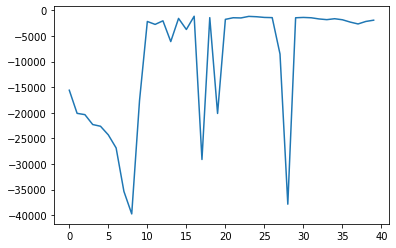

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.3], 'a': 80.24106460902817, 'b': 88.86525734786015}


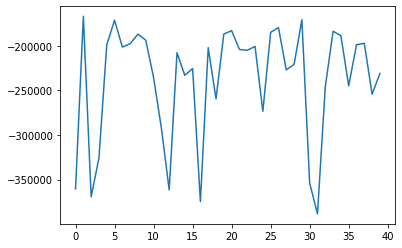

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.1], 'a': 71.0183917283622, 'b': 82.45740219166736}


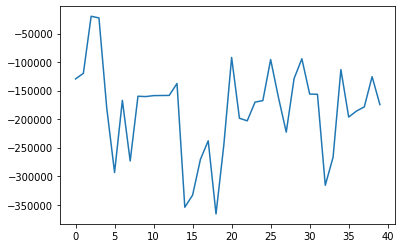

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.3, 0.1], 'a': 35.175243929640864, 'b': 99.35820714198844}


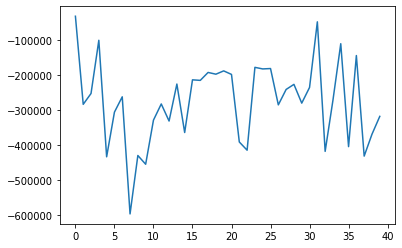

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.05, 0.05], 'a': 30.482279236541633, 'b': 1.5528242948011362}


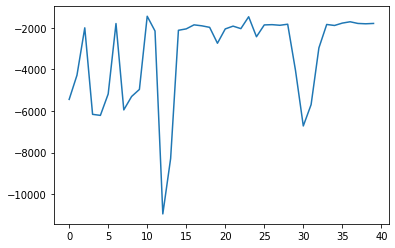

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.1, 0.5], 'a': 14.558020848616671, 'b': 59.86117424222037}


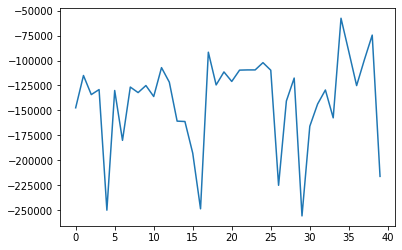

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.3, 0.3], 'a': 66.06528304537771, 'b': 56.51444763846703}


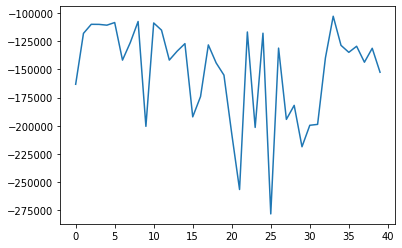

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 37.11048542137208, 'b': 28.726433602430934}


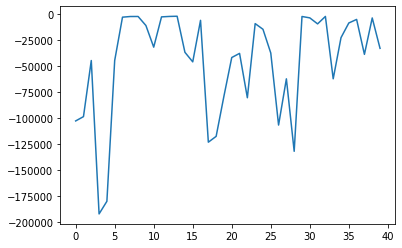

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.1, 0.5], 'a': 61.625634538330665, 'b': 89.60747651121687}


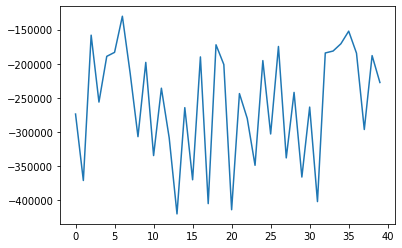

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.3], 'a': 47.863250905121056, 'b': 90.5629943059813}


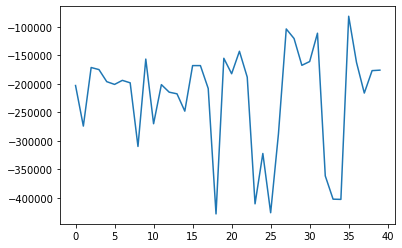

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.1], 'a': 9.102124923590782, 'b': 33.64873147472069}


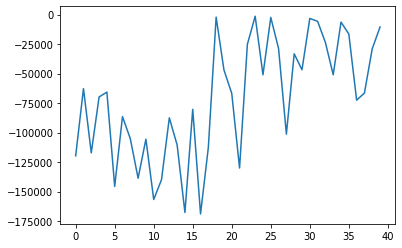

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.3], 'a': 86.67639731224051, 'b': 67.64087605744216}


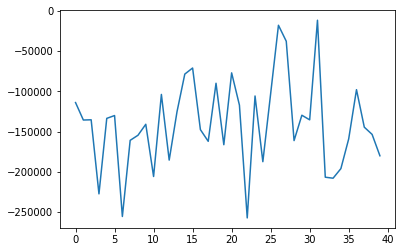

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.5], 'a': 65.48362370961162, 'b': 78.33619730950647}


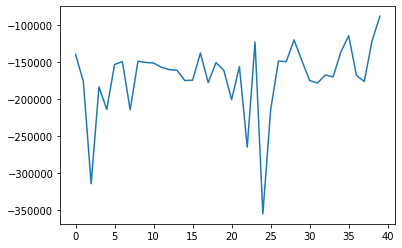

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.3, 0.3], 'a': 37.981434874900756, 'b': 90.37166792912767}


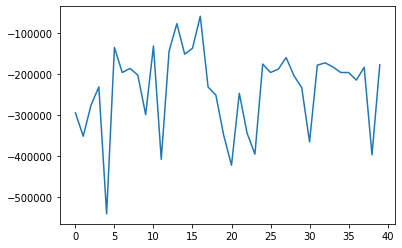

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.1, 0.01], 'a': 16.905939078364153, 'b': 25.38644411531624}


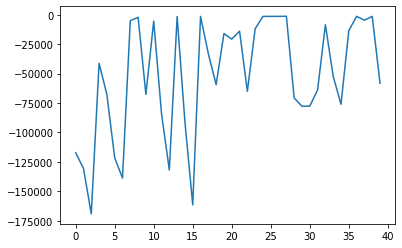

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.01, 0.01], 'a': 59.65516866096977, 'b': 83.0024903780458}


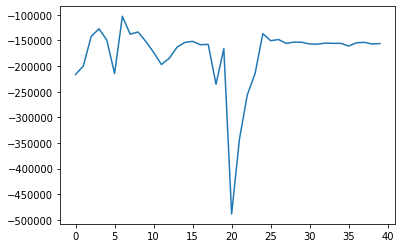

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.3, 0.05], 'a': 38.692517292245064, 'b': 54.13167207083933}


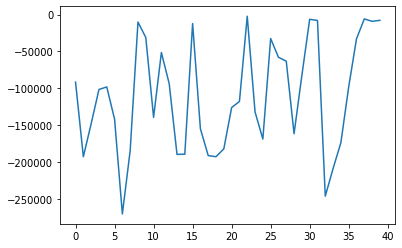

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.05], 'a': 12.388867188446707, 'b': 62.983440737991714}


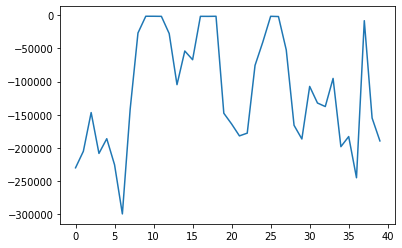

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.05, 0.05], 'a': 33.10293248264647, 'b': 86.93539492215471}


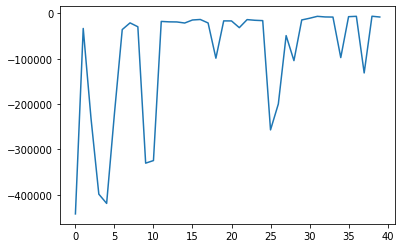

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.3, 0.5], 'a': 34.05469533448073, 'b': 3.325515767543441}


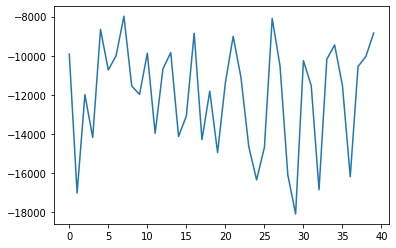

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 86.62541188293929, 'b': 18.51238055638146}


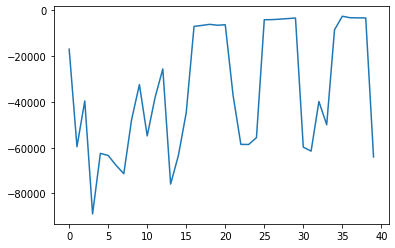

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.05], 'a': 76.23838823457227, 'b': 54.901735979151375}


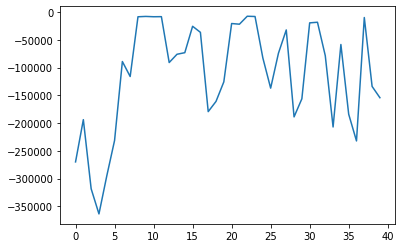

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.3], 'a': 38.078372142083964, 'b': 10.199269943988664}


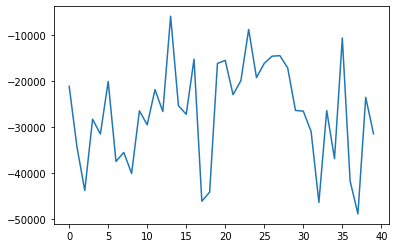

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.05], 'a': 35.31008233668154, 'b': 17.099291153101547}


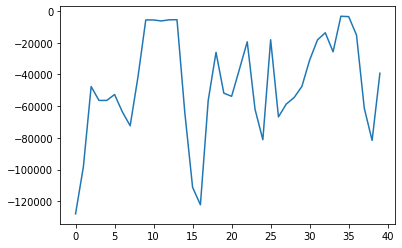

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.01, 0.3], 'a': 7.293840316754208, 'b': 47.24245805963933}


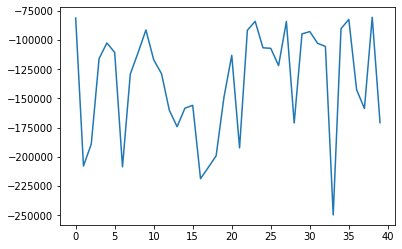

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.5], 'a': 61.163957798717064, 'b': 7.952621882001121}


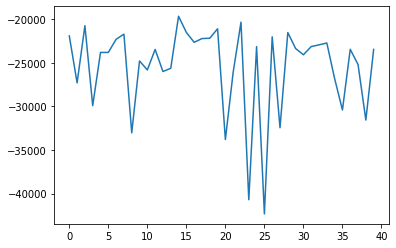

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.1], 'a': 19.631723992722073, 'b': 90.89399695382724}


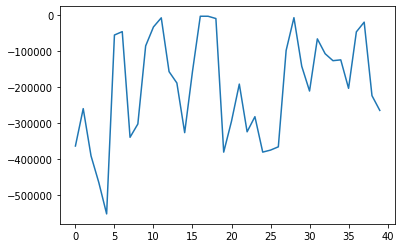

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.5], 'a': 95.57693543736421, 'b': 2.177577325459501}


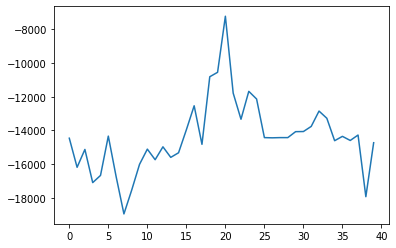

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.05], 'a': 40.88353256337606, 'b': 37.02997958816052}


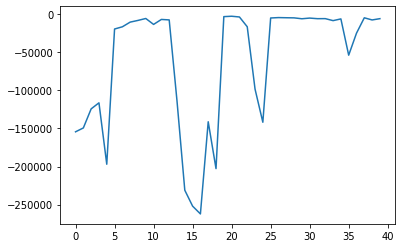

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.3], 'a': 81.36656852503047, 'b': 3.824933746480619}


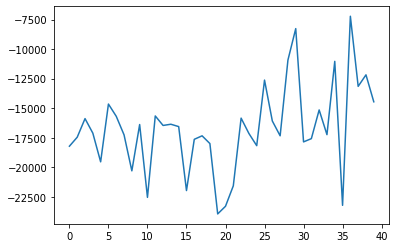

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.5], 'a': 12.925971815968518, 'b': 56.758049015658486}


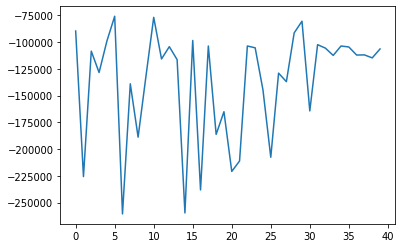

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.3, 0.1], 'a': 13.162472762498002, 'b': 13.9073111849635}


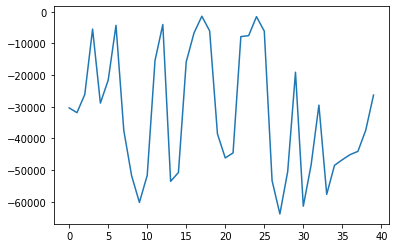

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.01, 0.3], 'a': 38.30771262372168, 'b': 69.40142467188424}


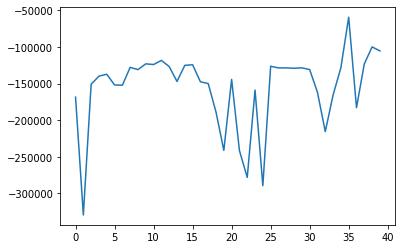

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.3, 0.5], 'a': 57.45715797856539, 'b': 67.73406701449281}


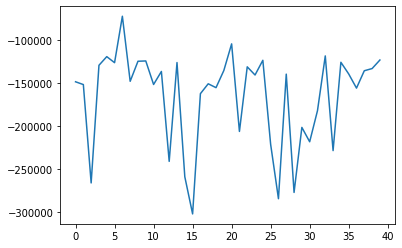

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.05], 'a': 3.8451314810704518, 'b': 75.30871587138085}


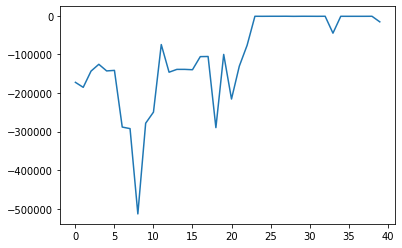

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.5, 0.05], 'a': 46.551753081846655, 'b': 92.21278958265626}


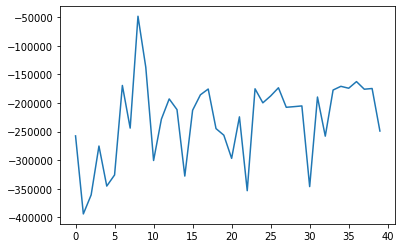

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.05, 0.3], 'a': 29.474019117817985, 'b': 48.66371193194083}


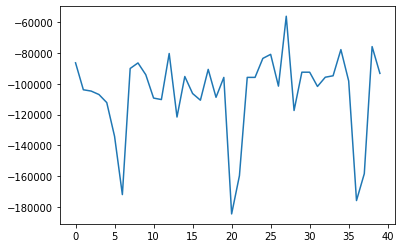

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.01, 0.3], 'a': 36.199465535324016, 'b': 23.610235892868637}


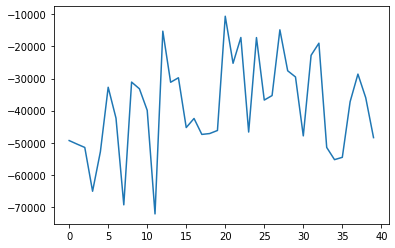

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.3, 0.05], 'a': 44.77343806041614, 'b': 68.43491771871754}


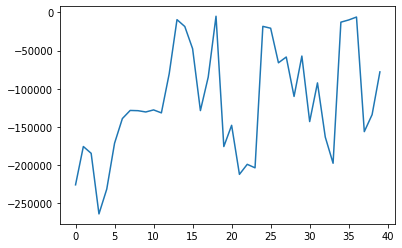

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.01, 0.3], 'a': 88.72234250692527, 'b': 2.4187589713096425}


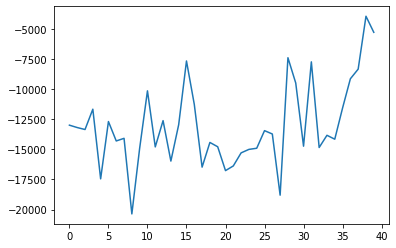

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.01, 0.01], 'a': 47.12196762769857, 'b': 46.18026245492456}


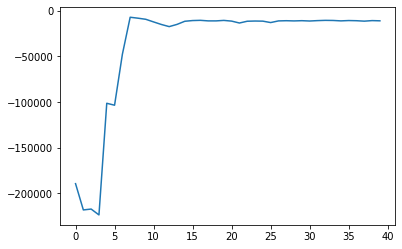

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.3], 'a': 43.334720988676324, 'b': 62.16697223787276}


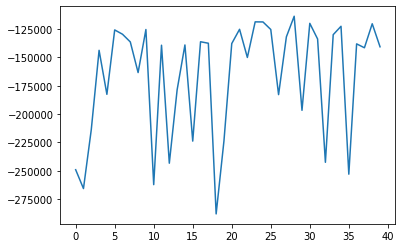

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.5, 0.5], 'a': 0.32362407519364034, 'b': 9.249032637297317}


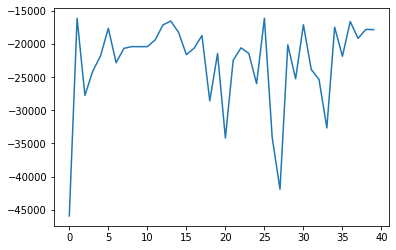

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.1], 'a': 49.96297038536524, 'b': 66.2590356170871}


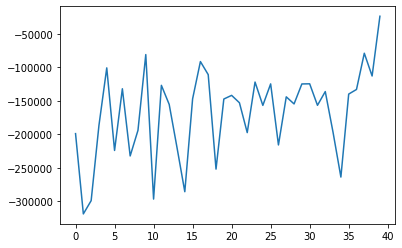

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.01], 'a': 91.50938109949848, 'b': 82.2788302469936}


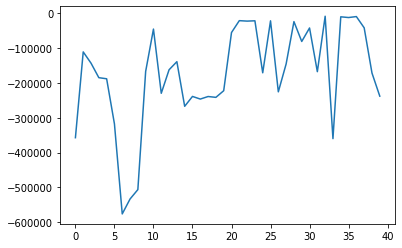

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.1], 'a': 5.875674549244381, 'b': 12.121750960539524}


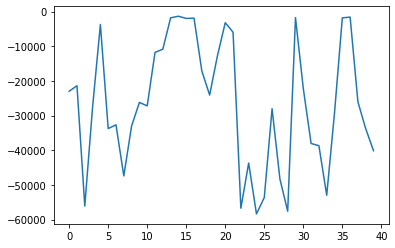

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.1], 'a': 87.01405808518442, 'b': 3.7966605377096285}


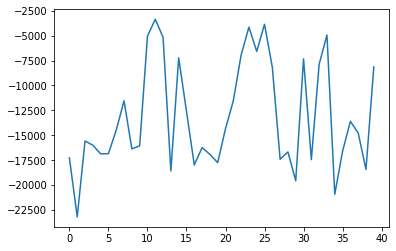

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.5], 'a': 34.9451691845735, 'b': 96.69724403137816}


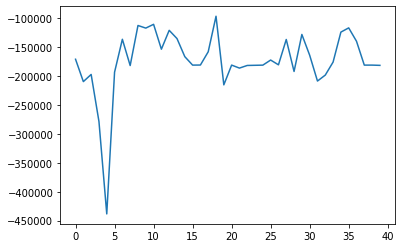

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.1, 0.3], 'a': 7.94897299999241, 'b': 26.50048835780321}


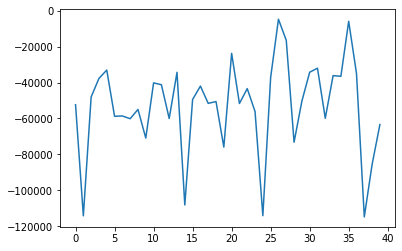

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.01, 0.1], 'a': 96.93304785161591, 'b': 97.38529034482214}


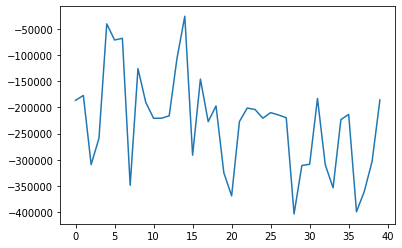

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.05, 0.05], 'a': 54.55410001705771, 'b': 57.587019644130855}


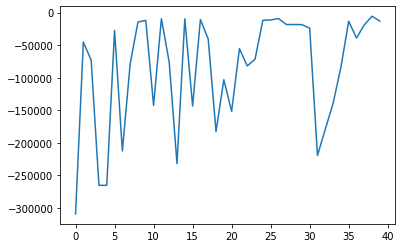

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.3, 0.1], 'a': 42.28162083119196, 'b': 11.17007749478951}


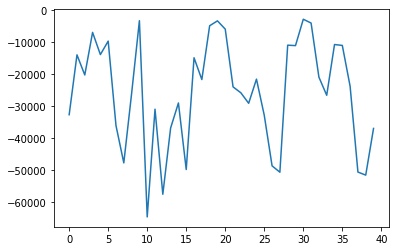

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.3, 0.05], 'a': 22.69976179208847, 'b': 48.46168294373394}


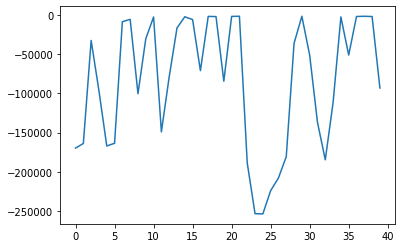

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.01, 0.05], 'a': 11.650211002786126, 'b': 83.1692248331716}


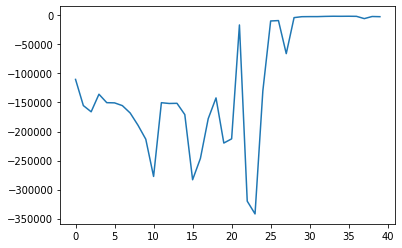

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.5, 0.1], 'a': 49.270959939481074, 'b': 84.29120236144941}


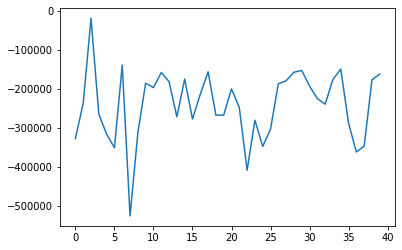

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.05, 0.3], 'a': 59.8777717773035, 'b': 18.740453962135216}


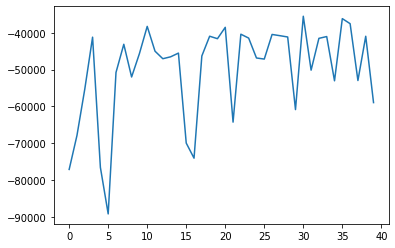

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.1, 0.5], 'a': 79.85944385614133, 'b': 37.288767011234}


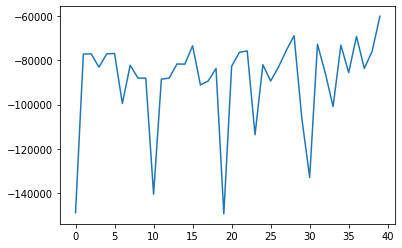

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.05, 0.01], 'a': 9.568175589117567, 'b': 97.74696607353283}


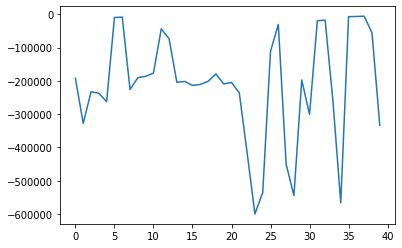

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.3, 0.05], 'a': 48.512496275958384, 'b': 87.6947817221889}


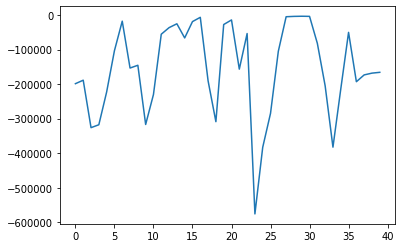

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.1], 'a': 47.51567822322901, 'b': 53.82888969937939}


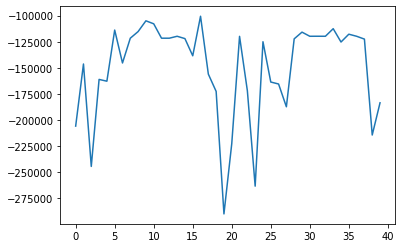

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.05, 0.01], 'a': 88.80325862191927, 'b': 77.84455217602316}


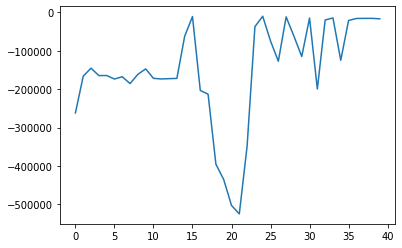

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.3], 'a': 11.8586576675069, 'b': 71.09061683517929}


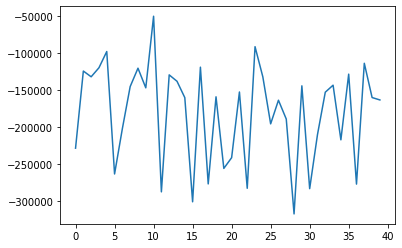

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.1, 0.05], 'a': 50.23590633256391, 'b': 41.407568948839945}


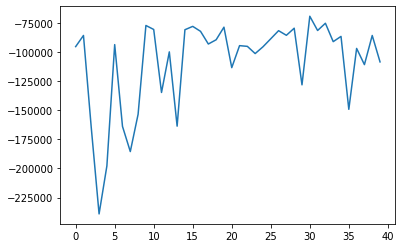

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.05, 0.3], 'a': 64.72646365099135, 'b': 30.429353809538107}


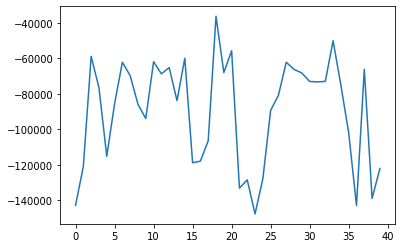

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.05, 0.5], 'a': 84.44986714218075, 'b': 58.67843648516964}


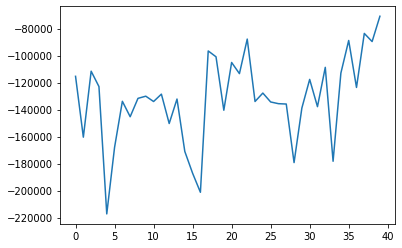

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.01, 0.05], 'a': 51.346999139040605, 'b': 49.433283183889685}


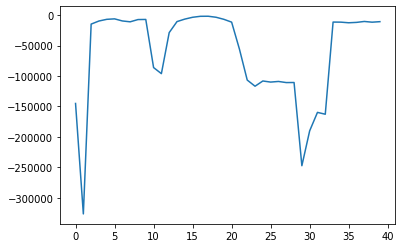

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.05, 0.01], 'a': 99.36347667089346, 'b': 65.67731405108236}


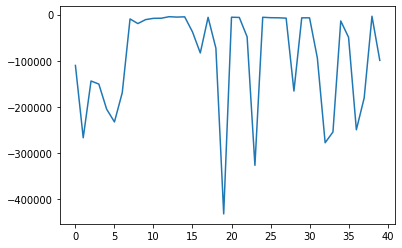

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.3, 0.3], 'a': 3.9098919571314616, 'b': 36.4723034988235}


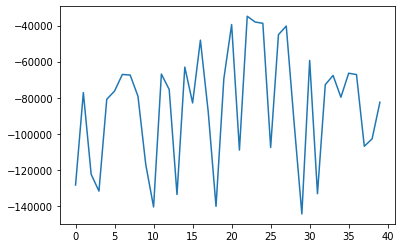

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.5], 'a': 42.62085977397982, 'b': 36.379741696555556}


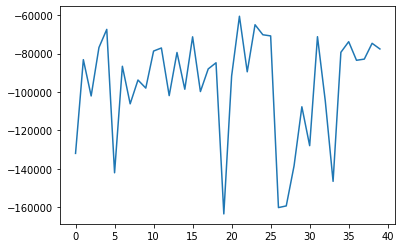

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.5, 0.05], 'a': 5.197226165071989, 'b': 46.661058150103294}


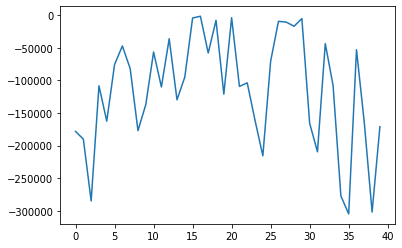

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.1], 'a': 87.19710611913621, 'b': 28.73544393834324}


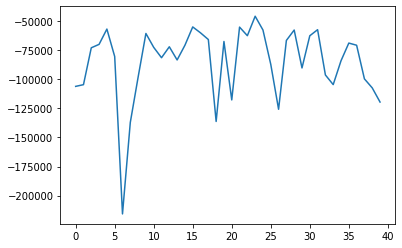

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.5, 0.05], 'a': 76.51259180433664, 'b': 88.82443431067318}


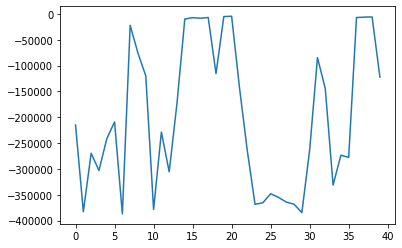

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.1, 0.1], 'a': 94.74445436451231, 'b': 73.34782069974263}


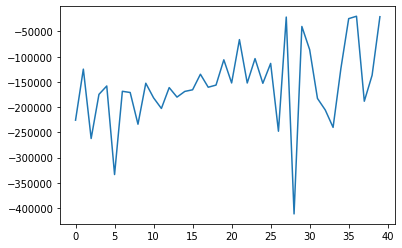

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.05], 'a': 31.36829309662189, 'b': 88.73207894573885}


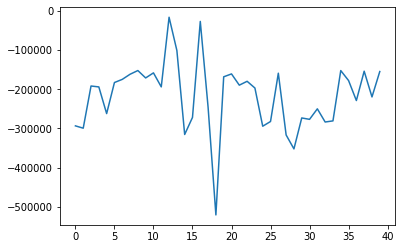

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.1, 0.1], 'a': 73.71176822597079, 'b': 66.35066801837377}


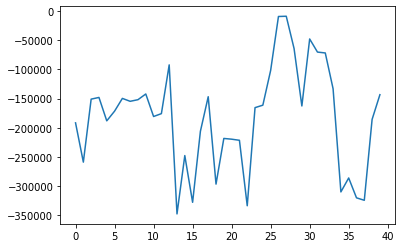

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.01, 0.1], 'a': 64.06319862652481, 'b': 29.344113764130775}


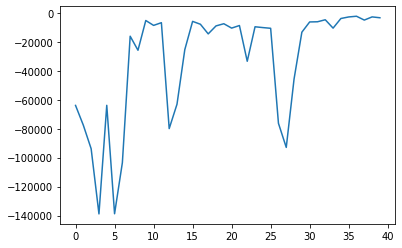

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.05], 'a': 59.1559518328457, 'b': 36.52461864082277}


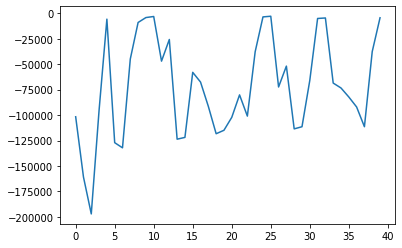

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.1, 0.05], 'a': 98.3181858852511, 'b': 63.65437811527161}


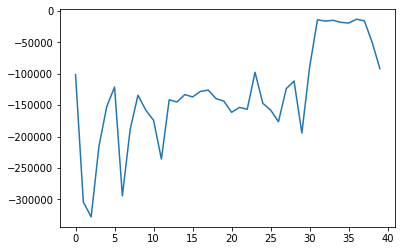

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.3, 0.05], 'a': 62.83677963189967, 'b': 9.551643957262678}


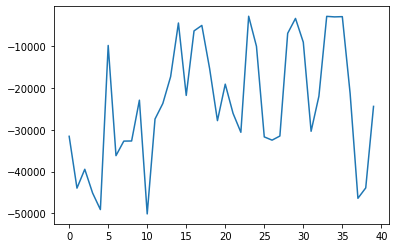

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.05, 0.1], 'a': 51.652710053995236, 'b': 3.118403495851896}


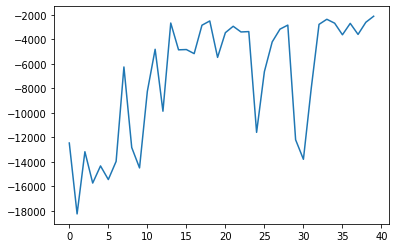

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.3, 0.05], 'a': 75.18391095606323, 'b': 60.63321942720332}


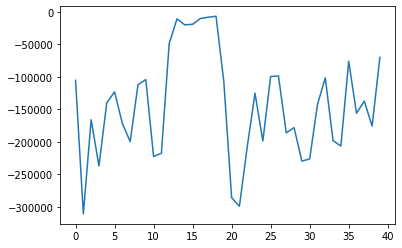

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.3, 0.3], 'a': 50.935282383193915, 'b': 0.3470459078183108}


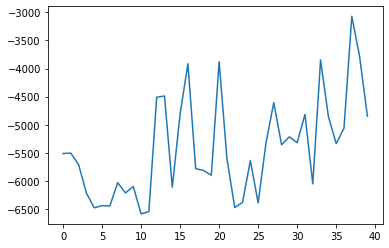

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.5, 0.1], 'a': 75.41957068887439, 'b': 41.36914432714784}


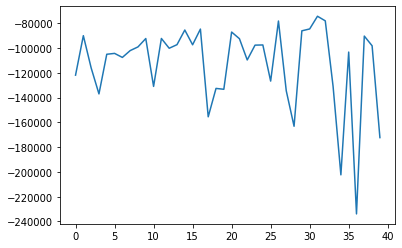

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.5, 0.5], 'a': 8.85287272744617, 'b': 47.296060476329785}


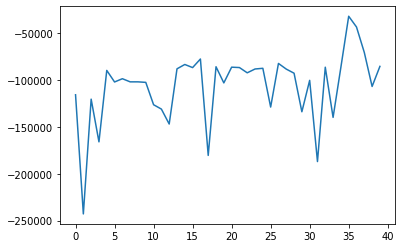

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.3, 0.3], 'a': 68.45678428031428, 'b': 51.18281944544205}


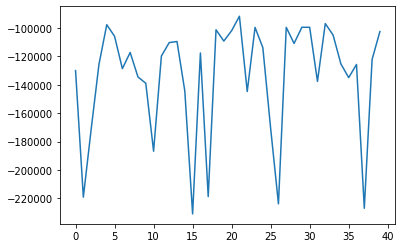

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.05], 'a': 49.078971485804615, 'b': 62.31641787651151}


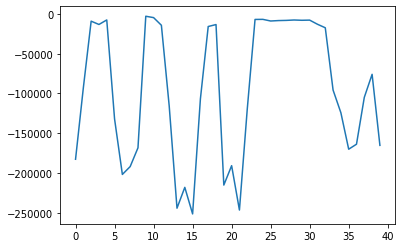

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.01, 0.05], 'a': 72.6720925711208, 'b': 96.3461582652179}


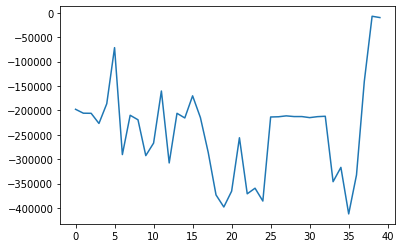

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.05, 'noise_std': [0.1, 0.05], 'a': 77.96348676593337, 'b': 9.928829080001321}


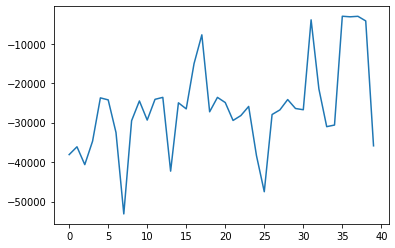

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.3, 0.01], 'a': 58.086680654225276, 'b': 85.56435484762895}


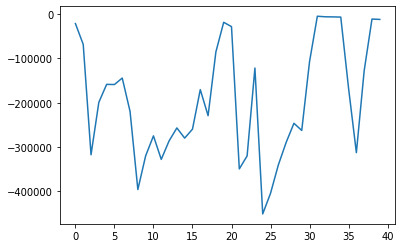

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.01, 0.1], 'a': 23.49170824043404, 'b': 60.2343529055237}


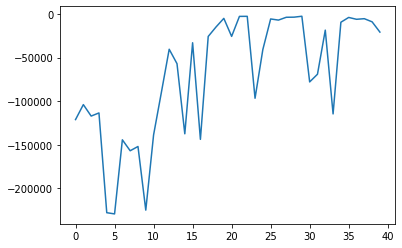

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.005, 'noise_std': [0.5, 0.05], 'a': 84.30794278753551, 'b': 66.77056628981559}


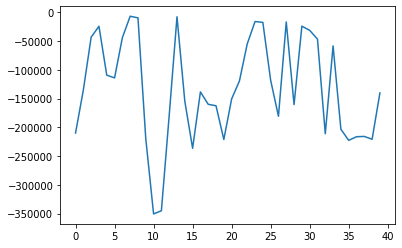

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.01, 0.1], 'a': 52.1301173126806, 'b': 73.60303070106862}


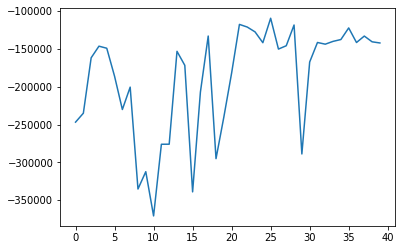

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.5, 0.01], 'a': 75.07666651042463, 'b': 48.98365094011636}


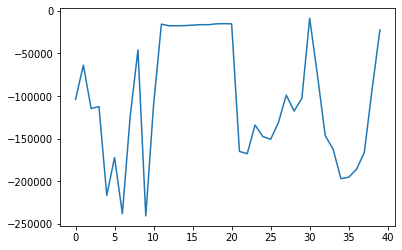

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 2e-05, 'tau': 0.005, 'noise_std': [0.1, 0.5], 'a': 26.901321578470984, 'b': 37.97795549608627}


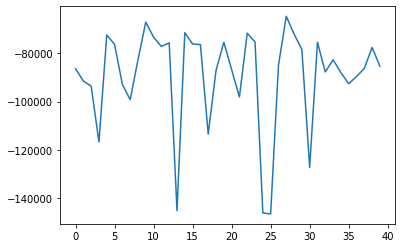

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.05, 0.01], 'a': 28.34332405779478, 'b': 24.149247319098478}


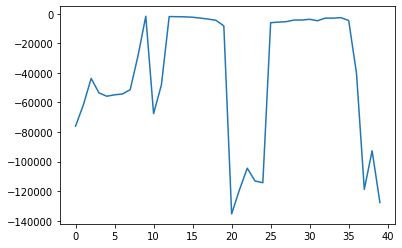

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 2e-05, 'tau': 0.001, 'noise_std': [0.5, 0.05], 'a': 32.42584337567544, 'b': 24.325823071860764}


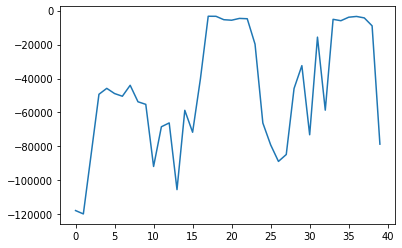

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.3, 0.05], 'a': 68.40471073533185, 'b': 87.10193360674553}


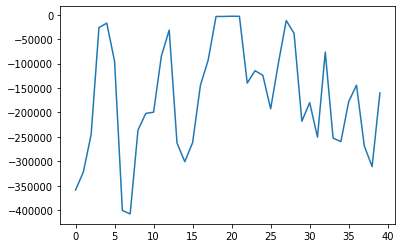

{'learning_rate_actor': 1e-05, 'learning_rate_critic': 0.0002, 'tau': 0.001, 'noise_std': [0.01, 0.01], 'a': 40.82316756935508, 'b': 98.0649619214463}


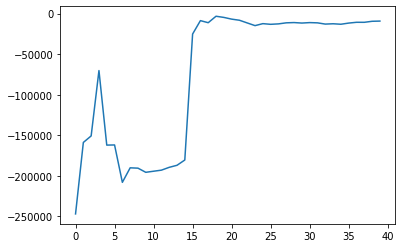

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.1, 0.3], 'a': 3.5000195165302617, 'b': 18.199895975291568}


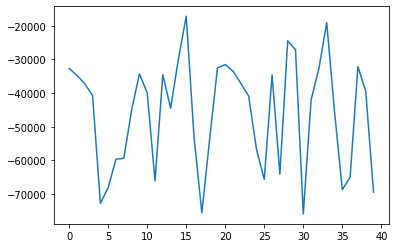

{'learning_rate_actor': 0.0001, 'learning_rate_critic': 0.0002, 'tau': 0.05, 'noise_std': [0.5, 0.3], 'a': 16.769084184704, 'b': 24.08661548161185}


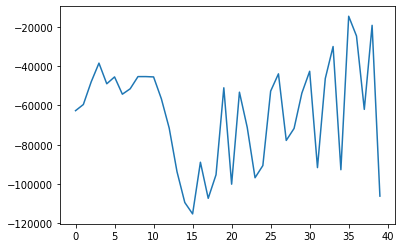

In [27]:
for key, item in scores.items():
    print(key)
    plt.plot(item)
    plt.show()

In [ ]:
eps_rewards, observations, actions = play(env, agent, n_games= 2, input_interval=input_interval, plot=False, watch=False)

NameError: name 'play' is not defined

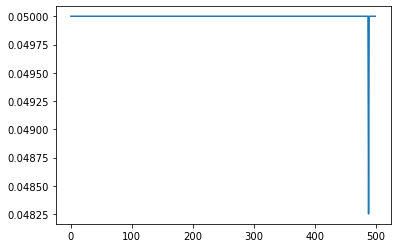

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(actions[0])[:,0])
plt.show()

In [ ]:
observations[10]

[array([2., 2., 0.], dtype=float32),
 array([ 0.5316863,  2.       , -1.036303 ], dtype=float32),
 array([ 0.59702015,  1.8896329 , -2.4476151 ], dtype=float32),
 array([-0.8059858 ,  0.72226906,  2.3406076 ], dtype=float32),
 array([ 0.5860138, -0.7138149,  1.8527681], dtype=float32),
 array([ 1.1420485, -2.6332252,  2.488728 ], dtype=float32),
 array([ 2.1995776, -3.4419541,  2.7978926], dtype=float32),
 array([ 0.38015297, -2.7907724 , -2.9543455 ], dtype=float32),
 array([ 2.3322213, -2.4209204, -2.2481961], dtype=float32),
 array([ 3.5810652, -0.8683461, -1.103149 ], dtype=float32),
 array([ 2.7094514,  0.857589 , -1.7294508], dtype=float32),
 array([ 2.9861379 ,  2.5868864 , -0.53444684], dtype=float32),
 array([ 2.5217843,  2.86174  , -2.166434 ], dtype=float32),
 array([ 1.8015221,  1.7990175, -2.8610733], dtype=float32),
 array([ 0.5860166,  1.4488102, -2.6726775], dtype=float32),
 array([-0.91191566,  0.6899551 ,  2.3388193 ], dtype=float32),
 array([ 0.47751334, -0.74861604,